In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive
import time
import math

large_number = 10e18
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
abs_path = os.getcwd()

# Load data

In [ ]:
def load_data(dataset, num_clusters):
  path = abs_path + dataset + '/clusters' + str(num_clusters) + '/'

  num = np.load(path + 'lam.npy')
  P = np.load(path + 'P.npy')
  sigma = np.load(path + 'Rvar.npy')

  rows = np.load(path + 'rows.npy')
  columns = np.load(path + 'columns.npy')

  utilde = np.load(path + 'Utilde.npy')
  v = np.load(path + 'V.npy')
  mu = np.dot(utilde.T, v)

  return mu, sigma

# Example clustering (not used if we use data from github)

In [ ]:
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from scipy.sparse import coo_matrix
import numpy as np

# Create user-item matrix (rows=users, cols=items)
row = np.array([0, 0, 1, 2, 2, 3])
col = np.array([0, 1, 2, 1, 2, 3])
data = np.array([1, 1, 1, 1, 1, 1])
matrix = coo_matrix((data, (row, col)), shape=(4, 4))

# Perform BLC on user-item matrix
model = NMF(n_components=2, init='random', random_state=0)
U = model.fit_transform(matrix)

# Cluster the users based on their latent features
kmeans = KMeans(n_clusters=3, random_state=0).fit(U)
clusters = kmeans.labels_
print(clusters)

[0 2 0 1]


# Cluster-based bandits

In [ ]:
def get_user_rating(g, v):
  sample = np.round(np.random.normal(mu[g, v], sigma[g, v], size=1)[0])

  if dataset == 'jester': # report point, this changes distributions
    if sample < -10:
      sample = -10
    if sample > 10:
      sample = 10
  else:
    if sample < 1:
      sample = 1
    if sample > 5:
      sample = 5

  return sample

In [ ]:
def g_func(g, h, v):
  if sigma[g, v] == 0: # report point, instability because of the division
    return large_number
  return ((mu[g, v] - mu[h, v]) * (mu[g, v] - mu[h, v])) / (sigma[g, v] * sigma[g, v])

In [ ]:
def sigma_func(g, h, v_prev):
  sum = 0
  for item in v_prev:
    sum += g_func(g, h, item['ind'])
  return sum

In [ ]:
def weight_func(v, g, h, v_prev):  
  return g_func(g, h, v) / sigma_func(g, h, v_prev)

In [ ]:
def r_func(g, h, v_prev):
  sum = 0
  for item in v_prev: # report point, instability because of the division
    sum += weight_func(item['ind'], g, h, v_prev) * (item['rating'] - mu[h, item['ind']]) / (mu[g, item['ind']] - mu[h, item['ind']]) 
  return sum

In [ ]:
def i_func(g, v_prev):
  min_init = False
  for h in range(num_clusters):
    if g == h: 
      continue

    r = r_func(g, h, v_prev)
    
    if not min_init:
      min = r
      min_init = True
      continue
    if r < min:
      min = r
      
  return min

In [ ]:
def explore(g_true, g_est, v_prev):
  # find the best cluster to distinguish from
  min_init = False
  for h in range(num_clusters):
    if h == g_est:
      continue

    sigma = sigma_func(g_est, h, v_prev)
    
    if not min_init:
      min_sum = sigma
      min_h = h
      min_init = True
      continue
    if sigma < min_sum:
      min_sum = sigma
      min_h = h
    
  # find which item is the best distinguisher
  max_init = False
  for v in range(mu.shape[1]):
    already_rated = False
    for v_rated in v_prev:
      if v_rated['ind'] == v:
        already_rated = True
        break
    if already_rated:
      continue
      
    if not max_init:
      max = g_func(g_est, min_h, v)
      max_v = v
      max_init = True
      continue
    if g_func(g_est, min_h, v) > max:
      max = g_func(g_est, min_h, v)
      max_v = v

  return {'ind':max_v, 'rating':get_user_rating(g_true, max_v)}

In [ ]:
def exploit(g_true, g_est, v_prev):
  # find which item has the best rating for estimated cluster
  max_init = False
  for v in range(mu.shape[1]):
    already_rated = False
    for v_rated in v_prev:
      if v_rated['ind'] == v:
        already_rated = True
        break
    if already_rated:
      continue
      
    if not max_init:
      max = mu[g_est, v]
      max_v = v
      max_init = True
      continue
    if mu[g_est, v] > max:
      max = mu[g_est, v]
      max_v = v

  return {'ind':max_v, 'rating':get_user_rating(g_true, max_v)}

In [ ]:
def cluster_based_bandits(mu, sigma, g_true, B, C, D, explore_on):
  v_prev = []
  g_est_vec = []
  max_iter = 25

  # initial estimation and exploration
  g_est = np.random.choice(range(num_clusters), size=1)[0]
  v_prev.append(explore(g_true, g_est, []))
  g_final_est = -1
  g_est_vec.append(g_est)

  # main loop
  for iter in range(max_iter):

    # define candidates
    g_candidates = []
    for g in range(num_clusters):
      if abs(i_func(g, v_prev) - 1) <= C:
        g_candidates.append(g)

    if len(g_candidates):
      # find cluster estimate
      i_max_init = False
      for g in range(num_clusters):  
        i = i_func(g, v_prev)
        if not i_max_init:
          i_max = i
          g_max = g
          i_max_init = True
          continue
        if i_max < i:
          i_max = i
          g_max = g
      
      g_est = g_max

      # explore or exploit
      if (g_final_est < 0) and explore_on:
        v_prev.append(explore(g_true, g_est, v_prev))
      else:
        v_prev.append(exploit(g_true, g_est, v_prev))

      # potential exit to exploitation phase
      sigma_min_init = False # report point, is it the goal to find minimal sigma, not stated in the paper
      for h in range(num_clusters):
        if g == h:
          continue
        if not sigma_min_init:
          sigma_min = sigma_func(g_est, h, v_prev)
          sigma_min_init = True
          continue
        sigma_min = min(sigma_min, sigma_func(g_est, h, v_prev))

      if (sigma_min >= B) or ((len(g_candidates) == 1) and (iter + 1 > D * math.log2(num_clusters))):
        g_final_est = g_est

    else:
      # find cluster estimate
      sigma_min_init = False
      for g in range(num_clusters):
        for h in range(num_clusters):
          if g == h: 
            continue
          sigma = sigma_func(g, h, v_prev)
          if not sigma_min_init:
            sigma_min = sigma
            min_pair = (g, h)
            sigma_min_init = True
            continue 
          if  sigma < sigma_min:
            sigma_min = sigma
            min_pair = (g, h)

      g_est, h = min_pair

      # explore or exploit
      if (g_final_est < 0) and explore_on:
        v_prev.append(explore(g_true, g_est, v_prev))
      else:
        v_prev.append(exploit(g_true, g_est, v_prev))
    
    g_est_vec.append(g_est)
    

  return g_est_vec, v_prev # report point, return estimation from the end of explore phase or from the end

In [ ]:
def find_best_unrated_items(g_true, v_vec):
  r_best = []
  for i in range(len(v_vec)):
    r_ = []
    for k in range(i + 1):
      max = -100
        
      for v in range(mu.shape[1]):
        already_rated = False
        
        for v_rated in v_vec[:i+1]:
          if v_rated['ind'] == v:
            already_rated = True
            break
        
        for v_rated in r_:
          if v_rated['ind'] == v:
            already_rated = True
            break

        if already_rated:
          continue

        if mu[g_true, v] > max:
          max = mu[g_true, v]
          max_v = v
      r_.append({'ind':max_v, 'rating':mu[g_true, max_v]})
    
    sum = 0
    for v in r_:
      sum += v['rating']
    r_best.append(sum)

  return r_best

# Evaluation

## All datasets and different clusters

In [ ]:
datasets = ['netflix', 'jester', 'goodreads']
num_of_clusters = [4, 8, 16]

## Significance test

In [ ]:
datasets = ['netflix']
num_of_clusters = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

## Experiment

In [ ]:
np.random.seed(42)

num_new_users = 1000
B = 5
C = 0.5
D = 3
exploration_on = True

for dataset in datasets:
  for num_clusters in num_of_clusters:
    (mu, sigma) = load_data(dataset, num_clusters)

    #regret = [0] * 25
    cnt_true_clusters = [0] * num_clusters
    cnt_clusters = [0] * num_clusters
    cnt_vec = [0] * 26
    #convergence_time = []

    for j in range(num_new_users):
      g_true = np.random.choice(range(num_clusters), size=1)[0]

      g_est_vec, v_vec = cluster_based_bandits(mu, sigma, g_true, B, C, D, exploration_on)

      cnt_vec = cnt_vec + (g_est_vec == g_true)
      cnt_clusters[g_true] += 1
      if g_est_vec[-1] == g_true:
        cnt_true_clusters[g_true] += 1

      #v_star = find_best_unrated_items(g_true, v_vec)
      #sum = 0
      #user_regret = []
      #for i, v in enumerate(v_vec):
      #  sum += v['rating']
      #  user_regret.append(sum - v_star[i])
      
      #converged = False
      #for i in range(len(regret)):
      #  regret[i] += user_regret[i]
      #  if not converged and (user_regret[i] > 0.8 * user_regret[-1]):
      #    convergence_time.append(i + 1)
      #    converged = True
      #if not converged:
      #  convergence_time.append(-1)

    #for i in range(len(regret)):
    #  regret[i] = regret[i] / num_new_users
      
    acc_vec = cnt_vec / num_new_users
    acc_clusters = [i / j for i, j in zip(cnt_true_clusters, cnt_clusters)]

    print(dataset)
    print(num_clusters)
    
    print(acc_vec[-1])
    #print(acc_clusters)

    #print(regret)
    #print(convergence_time)


netflix
4
0.855
netflix
4
0.873
netflix
4
0.839
netflix
4
0.852
netflix
4
0.862
netflix
4
0.858
netflix
4
0.854
netflix
4
0.829
netflix
4
0.859
netflix
4
0.829


## Visualize

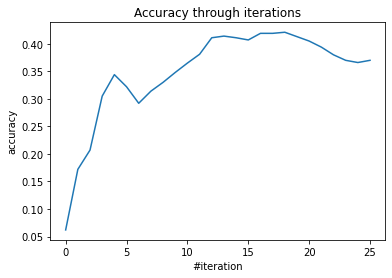

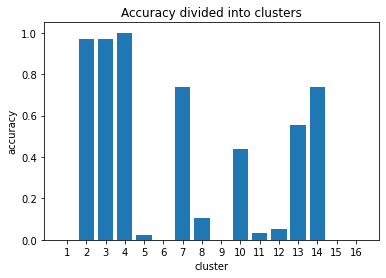

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc_vec)
plt.title("Accuracy through iterations")
plt.xlabel("#iteration")
plt.ylabel("accuracy")
plt.show()

plt.bar(range(len(acc_clusters)), acc_clusters)
plt.xticks(range(len(acc_clusters)), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])
plt.title("Accuracy divided into clusters")
plt.xlabel("cluster")
plt.ylabel("accuracy")
plt.show()